In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from typing import Callable

# **TODO**

* исправить calculate_maxsize_independed_set():

# **Создадим функции для реализации наших случайных величин**

*   Распределение Вейбулла, по умолчанию с параметрами $\space\space k = \frac{1}{2} ,\space\space\space$$\lambda = \frac{1}{\sqrt{10}}$

*   Гамма-распределение, по умолчанию с параметрами $\space\space k = \frac{1}{2} ,\space\space\space$$\lambda = \frac{1}{\sqrt{2}}$



In [3]:
WEIBULL_K_0 = 0.5
WEIBULL_LAMBDA_0 = 1 / np.sqrt(10)

GAMMA_K_0 = 0.5
GAMMA_LAMBDA_0 = 1 / np.sqrt(2)

In [4]:
def gen_weibull_points(num_points: int, k: float = WEIBULL_K_0, lambd: float = WEIBULL_LAMBDA_0) -> np.ndarray[np.float64]:
    """ Возвращает num_points точек сгенерированных по распределению Вейбулла W(k, lambd) """
    return lambd * np.random.weibull(k, num_points)


def gen_gamma_points(num_points: int, k: float = GAMMA_K_0, lambd: float = GAMMA_LAMBDA_0) -> np.ndarray[np.float64]:
    """ Возвращает num_points точек сгенерированных по гамма-распределению Gamm(k, lambd)"""
    return np.random.gamma(k, lambd, num_points)

# **Создадим класс графа для удобного хранения и работы.**

### **Договор про хранение графов**

**Граф храним специальным классом с полями:**

*   вершины графа храним списком.
$V_G = (x_{1}, x_{2}, \dots, x_{k})$

    где $k$ - количество вершин графа, $x_i$ - координата $i$-ой вершины

*  ребра графа храним множеством. $E_G = \{ (a_1, b_1), (a_2, b_2), \dots\}$

    где $\space\space a_i < b_i\space\space$ - номера вершин

*  Также храним обьект NetworkX.Graph для удобного использования разных алгоритмов на графах

**Класс имеет 3 метода - 2 для построение ребер, соответсвующих KNN и Distance графам и 1 для визуализации.**


In [5]:
class Graph:
    def __init__(self, points: np.ndarray[float], edges: set[tuple[int, int]] = set()) -> None:
        self.V = points
        self.E = edges
        self.nx_obj = nx.empty_graph(len(points))
        self.nx_obj.add_edges_from(edges)


    def build_KNN_graph(self, K: int) -> None:
        """ Строит ребра KNN графа """
        self.E = set()

        for idx_1, x_1 in enumerate(self.V):
            dist = []
            for idx_2, x_2 in enumerate(self.V):
                dist.append([np.linalg.norm(x_1 - x_2), idx_2])
            for nearest in sorted(dist)[1:K+1]:
                self.E.add( (min(idx_1, nearest[1]), max(idx_1, nearest[1])) )

        self.nx_obj.clear_edges()
        self.nx_obj.add_edges_from(self.E)

    def build_dist_graph(self, max_dist: int) -> None:
        """ Строит ребра Distance графа """
        self.E = set()

        for idx_1, x_1 in enumerate(self.V):
            dist = []
            for idx_2, x_2 in enumerate(self.V):
                if (idx_2 <= idx_1):
                    continue
                if np.linalg.norm(x_1 - x_2) <= max_dist:
                    self.E.add( (idx_1, idx_2) )

        self.nx_obj.clear_edges()
        self.nx_obj.add_edges_from(self.E)

    def draw(self) -> None:
        """ Рисует граф """
        if (len(self.V) == 0):
            print("Пустой граф.")
            return

        for e in self.E:
            x1, y1 = self.V[e[0]], e[0]
            x2, y2 = self.V[e[1]], e[1]
            plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1)
        plt.scatter(self.V, range(len(self.V)), color="blue")
        plt.title("Наш граф")
        plt.xlabel("Ее координата")
        plt.ylabel("Номер вершины")

## Демонстрация работы

Создадим **Distance** граф с **max_distance=0.15** вершины которого представляют собой реализации

случайной величины (в нашем случае с гамма-распределением с параметрами $\space\space k = \frac{1}{2} ,\space\space\space$$\lambda = \frac{1}{\sqrt{2}}$)

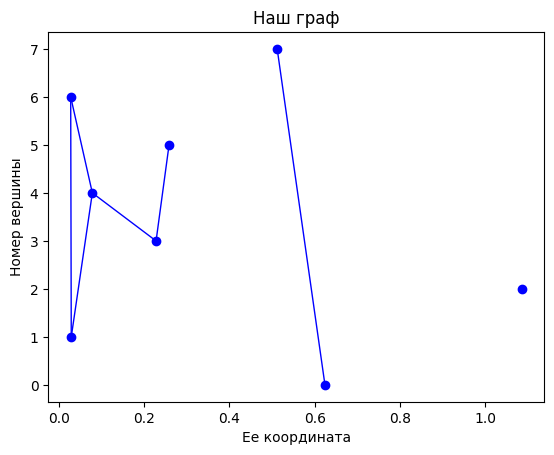

In [11]:
Distance_Gamma = Graph(points = gen_gamma_points(8))

Distance_Gamma.build_dist_graph(max_dist = 0.15)

Distance_Gamma.draw()

Создадим **2_NN** граф вершины которого представляют собой реализации случайной

величины (в нашем случае с распределением Вейбулла с параметрами $\space\space k = \frac{1}{2} ,\space\space\space$$\lambda = \frac{1}{\sqrt{10}}$)

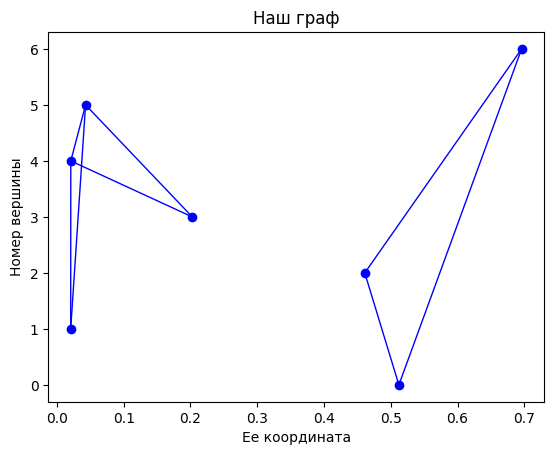

In [15]:
TwoNN_Weibull = Graph(points = gen_weibull_points(7))

TwoNN_Weibull.build_KNN_graph(K = 2)

TwoNN_Weibull.draw()

# **Напишем функции для подсчета характеристик.**

Некоторые функции мы не будем реализовывать, потому что соответсвующие величины ищутся любо приблеженно, либо слишком медленно

In [53]:
def calculate_min_deg(G: Graph) -> int:
    """ Возвращает минимальную степень вершин графа """
    min_degree_node, min_degree = min(G.nx_obj.degree(), key=lambda x: x[1])
    return min_degree


def calculate_max_deg(G: Graph) -> int:
    """ Возвращает максимальную степень вершин графа """
    max_degree_node, max_degree = max(G.nx_obj.degree(), key=lambda x: x[1])
    return max_degree


def calculate_number_component(G: Graph) -> int:
    """ Возвращает число компонент связности графа """
    return nx.number_connected_components(G.nx_obj)


def calculate_number_articul(G: Graph) -> int:
    """ Возвращает число точек сочленения графа """
    return len(list(nx.articulation_points(G.nx_obj)))


def calculate_number_triangle(G: Graph) -> int:
    """ Возвращает число триугольников графа """
    triangles_dict =  nx.triangles(G.nx_obj)
    return sum(triangles_dict.values()) // 3


def calculate_clique_number(G: Graph) -> int:
    """ Возвращает кликовое число графа """
    max_cliques = list(nx.find_cliques(G.nx_obj))
    return max([len(clique) for clique in max_cliques])


def calculate_maxsize_independed_set(G: Graph) -> int:
    """ Возвращает размер максимального независемого множества """
    G_compl = nx.complement(G.nx_obj)
    return calculate_clique_number(G_compl)

In [58]:
human_readable_characts = {"calculate_min_deg": "Минимальная степень вершины",
                           "calculate_max_deg": "Максимальная степень вершины",
                           "calculate_number_component": "Количество компонент связности",
                           "calculate_number_articul": "Количество точек сочленения",
                           "calculate_number_triangle": "Количество треугольников",
                           "calculate_clique_number": "Кликовое число",
                           "calculate_maxsize_independed_set": "Размер наибольшего независимого множества" }

## **Немного тестов**

Считаем что мы умненькие и исследуем хорошие, непустые графы без петель и кратных ребер.

### Тесты на минимальную степень вершины

In [39]:
# Тест 1: Одна вершина без ребер
G1 = Graph([np.array([0.0])])
assert calculate_min_deg(G1) == 0, "Тест 1 (1 вершина без ребер) не пройден"

# Тест 2: Две вершины без ребер
G2 = Graph([np.array([0.0]), np.array([1.0])])
assert calculate_min_deg(G2) == 0, "Тест 2 (2 вершины без ребер) не пройден"

# Тест 3: Две вершины с одним ребром
G3 = Graph([np.array([0.0]), np.array([1.0])], {(0, 1)})
assert calculate_min_deg(G3) == 1, "Тест 3 (2 вершины с ребром) не пройден"

# Тест 4: Треугольник (все степени равны 2)
G4 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2), (2, 0)})
assert calculate_min_deg(G4) == 2, "Тест 4 (треугольник) не пройден"

# Тест 5: Граф с висячей вершиной
G5 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (0, 2)})
assert calculate_min_deg(G5) == 1, "Тест 5 (висячая вершина) не пройден"

# Тест 6: Граф с изолированной вершиной
G6 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1)})
assert calculate_min_deg(G6) == 0, "Тест 6 (изолированная вершина) не пройден"

# Тест 7: Граф-звезда с 4 вершинами
G7 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3)})
assert calculate_min_deg(G7) == 1, "Тест 7 (граф-звезда) не пройден"

# Тест 8: Граф с разными степенями вершин
G8 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (1, 2), (2, 3)})
assert calculate_min_deg(G8) == 1, "Тест 8 (разные степени) не пройден"

print("Все 8 тестов для calculate_min_deg прошли успешно!")

Все 8 тестов для calculate_min_deg прошли успешно!


### Тесты на максимальную степень.

In [40]:
# Тест 1: Одна вершина без ребер
G1 = Graph([np.array([0.0])])
assert calculate_max_deg(G1) == 0, "Тест 1 (1 вершина без ребер) не пройден"

# Тест 2: Две вершины без ребер
G2 = Graph([np.array([0.0]), np.array([1.0])])
assert calculate_max_deg(G2) == 0, "Тест 2 (2 вершины без ребер) не пройден"

# Тест 3: Две вершины с одним ребром
G3 = Graph([np.array([0.0]), np.array([1.0])], {(0, 1)})
assert calculate_max_deg(G3) == 1, "Тест 3 (2 вершины с ребром) не пройден"

# Тест 4: Треугольник (все степени равны 2)
G4 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2), (2, 0)})
assert calculate_max_deg(G4) == 2, "Тест 4 (треугольник) не пройден"

# Тест 5: Граф с центральной вершиной
G5 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (0, 2)})
assert calculate_max_deg(G5) == 2, "Тест 5 (центральная вершина) не пройден"

# Тест 6: Граф с изолированной вершиной
G6 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1)})
assert calculate_max_deg(G6) == 1, "Тест 6 (изолированная вершина) не пройден"

# Тест 7: Граф-звезда с 4 вершинами
G7 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3)})
assert calculate_max_deg(G7) == 3, "Тест 7 (граф-звезда) не пройден"

# Тест 8: Граф с разными степенями вершин
G8 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (1, 2), (2, 3)})
assert calculate_max_deg(G8) == 3, "Тест 8 (разные степени) не пройден"

print("Все 8 тестов для calculate_max_deg прошли успешно!")

Все 8 тестов для calculate_max_deg прошли успешно!


### Тесты на количество компонент связности

In [41]:
# Тест 1: Одна вершина без ребер
G1 = Graph([np.array([0.0])])
assert calculate_number_component(G1) == 1, "Тест 1 (1 вершина) не пройден"

# Тест 2: Две изолированные вершины
G2 = Graph([np.array([0.0]), np.array([1.0])])
assert calculate_number_component(G2) == 2, "Тест 2 (2 изолированные вершины) не пройден"

# Тест 3: Две связанные вершины
G3 = Graph([np.array([0.0]), np.array([1.0])], {(0, 1)})
assert calculate_number_component(G3) == 1, "Тест 3 (2 связанные вершины) не пройден"

# Тест 4: Три вершины, две связаны
G4 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1)})
assert calculate_number_component(G4) == 2, "Тест 4 (3 вершины, 2 связаны) не пройден"

# Тест 5: Треугольник (1 компонента)
G5 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2), (2, 0)})
assert calculate_number_component(G5) == 1, "Тест 5 (треугольник) не пройден"

# Тест 6: Две отдельные компоненты
G6 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (2, 3)})
assert calculate_number_component(G6) == 2, "Тест 6 (2 компоненты) не пройден"

# Тест 7: Три компоненты (1 пара и 2 одиночные)
G7 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(1, 2)})
assert calculate_number_component(G7) == 3, "Тест 7 (3 компоненты) не пройден"

# Тест 8: Сложная структура (3 компоненты)
G8 = Graph([
    np.array([0.0]),  # компонента 1 (0-1-2)
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),  # компонента 2 (3-4)
    np.array([4.0]),
    np.array([5.0])   # компонента 3 (5)
], {(0, 1), (1, 2), (3, 4)})
assert calculate_number_component(G8) == 3, "Тест 8 (сложная структура) не пройден"

print("Все 8 тестов для calculate_number_component прошли успешно!")

Все 8 тестов для calculate_number_component прошли успешно!


### Тесты на количество точек сочленения

In [42]:
# Тест 1: Две вершины, соединенные ребром (нет точек сочленения)
G1 = Graph([np.array([0.0]), np.array([1.0])], {(0, 1)})
assert calculate_number_articul(G1) == 0, "Тест 1 (2 связанные вершины) не пройден"

# Тест 2: Три вершины в цепочке (центральная - точка сочленения)
G2 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2)})
assert calculate_number_articul(G2) == 1, "Тест 2 (цепочка из 3 вершин) не пройден"

# Тест 3: Треугольник (нет точек сочленения)
G3 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2), (2, 0)})
assert calculate_number_articul(G3) == 0, "Тест 3 (треугольник) не пройден"

# Тест 4: Граф-звезда (центр - точка сочленения)
G4 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3)})
assert calculate_number_articul(G4) == 1, "Тест 4 (граф-звезда) не пройден"

# Тест 5: Две компоненты, каждая с точкой сочленения
G5 = Graph([
    np.array([0.0]),  # компонента 1 (0-1-2)
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),  # компонента 2 (3-4-5)
    np.array([4.0]),
    np.array([5.0])
], {(0, 1), (1, 2), (3, 4), (4, 5)})
assert calculate_number_articul(G5) == 2, "Тест 5 (2 компоненты) не пройден"

# Тест 6: Граф с двумя точками сочленения
G6 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),
    np.array([4.0])
], {(0, 1), (1, 2), (2, 3), (3, 4), (1, 3)})
assert calculate_number_articul(G6) == 2, "Тест 6 (2 точки сочленения) не пройден"

# Тест 7: Граф без точек сочленения (все вершины степени 2)
G7 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (1, 2), (2, 3), (3, 0)})
assert calculate_number_articul(G7) == 0, "Тест 7 (цикл) не пройден"

# Тест 8: Сложный граф с несколькими точками сочленения
G8 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),
    np.array([4.0]),
    np.array([5.0]),
    np.array([6.0])
], {(0, 1), (1, 2), (2, 0), (1, 3), (3, 4), (4, 5), (5, 3), (3, 6)})
assert calculate_number_articul(G8) == 2, "Тест 8 (сложный граф) не пройден"

print("Все 8 тестов для calculate_number_articul прошли успешно!")

Все 8 тестов для calculate_number_articul прошли успешно!


### Тесты на количество треугольников

In [43]:
calculate_number_triangle# Тест 1: Граф с 3 вершинами без треугольников
G1 = Graph([np.array([0.0]), np.array([1.0]), np.array([2.0])], {(0, 1), (1, 2)})
assert calculate_number_triangle(G1) == 0, "Тест 1 (нет треугольников) не пройден"

# Тест 2: Один треугольник
G2 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0])
], {(0, 1), (1, 2), (2, 0)})
assert calculate_number_triangle(G2) == 1, "Тест 2 (1 треугольник) не пройден"

# Тест 3: Два раздельных треугольника
G3 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),
    np.array([4.0]),
    np.array([5.0])
], {(0, 1), (1, 2), (2, 0), (3, 4), (4, 5), (5, 3)})
assert calculate_number_triangle(G3) == 2, "Тест 3 (2 треугольника) не пройден"

# Тест 4: Треугольники с общей вершиной
G4 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)})
assert calculate_number_triangle(G4) == 2, "Тест 4 (2 треугольника с общей вершиной) не пройден"

# Тест 5: Полный граф K4 (4 треугольника)
G5 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)})
assert calculate_number_triangle(G5) == 4, "Тест 5 (K4 - 4 треугольника) не пройден"

# Тест 6: Граф с треугольником и дополнительными ребрами
G6 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (1, 2), (2, 0), (0, 3), (1, 3)})
assert calculate_number_triangle(G6) == 2, "Тест 6 (1 треугольник + доп. ребра) не пройден"

# Тест 7: Граф без треугольников (дерево)
G7 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0])
], {(0, 1), (0, 2), (0, 3)})
assert calculate_number_triangle(G7) == 0, "Тест 7 (дерево) не пройден"

# Тест 8: Сложный граф с 3 треугольниками
G8 = Graph([
    np.array([0.0]),
    np.array([1.0]),
    np.array([2.0]),
    np.array([3.0]),
    np.array([4.0])
], {(0, 1), (1, 2), (2, 0), (0, 3), (3, 4), (4, 0), (1, 3)})
assert calculate_number_triangle(G8) == 3, "Тест 8 (3 треугольника) не пройден"

print("Все 8 тестов для calculate_number_triangle прошли успешно!")

Все 8 тестов для calculate_number_triangle прошли успешно!


### Тесты на кликовое число

In [44]:
# Тест 1: Одна вершина (тривиальная клика)
G1 = nx.Graph()
G1.add_node(1)
assert calculate_clique_number(G1) == 1, "Тест 1 (1 вершина) не пройден"

# Тест 2: Две несвязанные вершины
G2 = nx.Graph()
G2.add_nodes_from([1, 2])
assert calculate_clique_number(G2) == 1, "Тест 2 (2 несвязанные вершины) не пройден"

# Тест 3: Две связанные вершины (ребро)
G3 = nx.Graph()
G3.add_edge(1, 2)
assert calculate_clique_number(G3) == 2, "Тест 3 (2 связанные вершины) не пройден"

# Тест 4: Треугольник (3 вершины, все связаны)
G4 = nx.Graph([(1, 2), (2, 3), (3, 1)])
assert calculate_clique_number(G4) == 3, "Тест 4 (треугольник) не пройден"

# Тест 5: Граф с кликой размера 4
G5 = nx.Graph([(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)])
assert calculate_clique_number(G5) == 4, "Тест 5 (клика K4) не пройден"

# Тест 6: Граф с несколькими кликами разного размера
G6 = nx.Graph([(1, 2), (2, 3), (3, 4), (1, 3), (2, 4)])
assert calculate_clique_number(G6) == 3, "Тест 6 (макс клика - треугольник) не пройден"

# Тест 7: "Звезда" (1 центральная вершина, связанная с несколькими)
G7 = nx.Graph([(1, 2), (1, 3), (1, 4), (1, 5)])
assert calculate_clique_number(G7) == 2, "Тест 7 (звезда) не пройден"

# Тест 8: Граф с изолированной вершиной и кликой
G8 = nx.Graph([(1, 2), (2, 3), (3, 1), (4, 5)])
assert calculate_clique_number(G8) == 3, "Тест 8 (клика + изолированные) не пройден"

print("Все 8 тестов для calculate_clique_number прошли успешно!")

Все 8 тестов для calculate_clique_number прошли успешно!


### Тесты на размер независимого множества

In [45]:
# Тест 1: Одна вершина (тривиальное независимое множество)
G1 = nx.Graph()
G1.add_node(1)
assert calculate_maxsize_independed_set(G1) == 1, "Тест 1 (1 вершина) не пройден"

# Тест 2: Две несвязанные вершины
G2 = nx.Graph()
G2.add_nodes_from([1, 2])
assert calculate_maxsize_independed_set(G2) == 2, "Тест 2 (2 несвязанные вершины) не пройден"

# Тест 3: Две связанные вершины (ребро)
G3 = nx.Graph()
G3.add_edge(1, 2)
assert calculate_maxsize_independed_set(G3) == 1, "Тест 3 (2 связанные вершины) не пройден"

# Тест 4: Треугольник (3 вершины, все связаны)
G4 = nx.Graph([(1, 2), (2, 3), (3, 1)])
assert calculate_maxsize_independed_set(G4) == 1, "Тест 4 (треугольник) не пройден"

# Тест 5: Граф без треугольников (макс. независимое множество = 2)
G5 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 5)])
assert calculate_maxsize_independed_set(G5) == 3, "Тест 5 (цепочка) не пройден"

# Тест 6: "Звезда" (1 центр + n вершин)
G6 = nx.Graph([(1, 2), (1, 3), (1, 4), (1, 5)])
assert calculate_maxsize_independed_set(G6) == 4, "Тест 6 (звезда) не пройден"

# Тест 7: Решетка 2x2
G7 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1)])
assert calculate_maxsize_independed_set(G7) == 2, "Тест 7 (решетка) не пройден"

# Тест 8: Граф с изолированной вершиной и кликой
G8 = nx.Graph([(1, 2), (2, 3), (3, 1), (4, 5)])
assert calculate_maxsize_independed_set(G8) == 2, "Тест 8 (клика + изолированные) не пройден"

print("Все 8 тестов для  calculate_maxsize_independed_set прошли успешно!")

Все 8 тестов для  calculate_maxsize_independed_set прошли успешно!


# **Напишем функцию для выичисления и визуализации распределения характеристики графа**

Она будет использоваться в обеих частях исследования.

In [67]:
def evaluate(
        num_samples: int = 420,                                 # количество реализация характеристики
        vector_size: int = 42,                                  # размерность случайного вектора
        gamma_k: float = GAMMA_K_0,                             # параметр k гамма-распределения
        gamma_lambda: float = GAMMA_LAMBDA_0,                   # параметр lambda гамма-распределения
        weibull_k: float = WEIBULL_K_0,                         # параметр k распределения Вейбулла
        weibull_lambda: float = WEIBULL_LAMBDA_0,               # параметр lambda распределения Вейбулла
        T_knn_foo: Callable[[Graph], int] = calculate_max_deg,  # функция вычисления характеристики для KNN графа
        knn_num_neighbours: int = 42,                           # количество соседей KNN графа
        T_dist_foo: Callable[[Graph], int] = calculate_max_deg, # функция вычисления характеристики для Distance графа
        dist_max_dist: int = 4.2,                               # макисмальная длина соединения Distance графа
        draw_distributions: bool = False                        # рисовать ли гистограммы распределения
) -> dict[str: list]:
    """
    Несколько раз симмулирует реализацию случайного вектора с некоторыми параметрами.
    Строит по ним KNN и Distance графы с некоторыми параметрами процедуры построения,
    вычисляет на них характеристики и визуализирует их распределение.
    Возвращает списки получившихся характеристик.
    """
    T_knn_gamma_list, T_knn_weibull_list = [], []
    T_dist_gamma_list, T_dist_weibull_list = [], []

    for i in range(num_samples):
        gamma_sample = gen_gamma_points(vector_size, gamma_k, gamma_lambda)
        weibull_sample = gen_weibull_points(vector_size, weibull_k, weibull_lambda)

        G_knn_gamma = Graph(points = gamma_sample)
        G_knn_gamma.build_KNN_graph(K = knn_num_neighbours)
        T_knn_gamma_list.append(T_knn_foo(G = G_knn_gamma))

        G_knn_weibull = Graph(points = weibull_sample)
        G_knn_weibull.build_KNN_graph(K = knn_num_neighbours)
        T_knn_weibull_list.append(T_knn_foo(G = G_knn_weibull))

        G_dist_gamma = Graph(points = gamma_sample)
        G_dist_gamma.build_dist_graph(max_dist = dist_max_dist)
        T_dist_gamma_list.append(T_dist_foo(G = G_dist_gamma))

        G_dist_weibull = Graph(points = weibull_sample)
        G_dist_weibull.build_dist_graph(max_dist = dist_max_dist)
        T_dist_weibull_list.append(T_dist_foo(G = G_dist_weibull))

    if draw_distributions:
        plt.figure(figsize=(16, 3))


        plt.subplot(1, 2, 1)
        plt.title(f"Распределение характеристики \'{human_readable_characts[T_knn_foo.__name__]}\' \nKNN граф.       " +
                  f"K={knn_num_neighbours} \n\nWeibull( {weibull_k},  {weibull_lambda} ) \nГ( { gamma_k},  {gamma_lambda} )")
        bins = np.arange(min(T_knn_gamma_list + T_knn_weibull_list), max(T_knn_gamma_list + T_knn_weibull_list) + 1, 1)
        plt.hist(T_knn_gamma_list, bins=bins, align="mid", alpha = 0.5, label="Гамма распределение")
        plt.hist(T_knn_weibull_list, bins=bins, align="mid", alpha = 0.5, label="Распределение Вейбулла")
        plt.xticks(bins)
        plt.xlabel("Значение характеристики")
        plt.ylabel("Количество графов")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Распределение характеристики \'{human_readable_characts[T_dist_foo.__name__]}\' \nDistance граф.       " +
                  f"max_distance_connected={dist_max_dist} \n\nWeibull( {weibull_k},  {weibull_lambda} ) \nГ( { gamma_k},  {gamma_lambda} ) ")
        bins = np.arange(min(T_dist_gamma_list + T_dist_weibull_list), max(T_dist_gamma_list + T_dist_weibull_list) + 1, 1)
        plt.hist(T_dist_gamma_list, bins=bins, align="mid", alpha = 0.5, label="Гамма распределение")
        plt.hist(T_dist_weibull_list, bins=bins, align="mid", alpha = 0.5, label="Распределение Вейбулла")
        plt.xticks(bins)
        plt.xlabel("Значение характеристики")
        plt.ylabel("Количество графов")
        plt.legend()

        plt.show()
        print()

    return { "T_knn_gamma_lists": T_knn_gamma_list,
             "T_knn_weibull_lists": T_knn_weibull_list,
             "T_dist_gamma_lists": T_dist_gamma_list,
             "T_dist_weibull_lists": T_dist_weibull_list }